# Starbucks Promotion Segmentation - Modeling

## Contents

### [Section I: Dependencies and Data](#load)
### [Section II: Data Preprocessing](#prep)
  ##### [1. Extract offers](#prep1)
  ##### [2. Encode categorical variables](#prep2)
  ##### [3. Create target label](#prep3)
  ##### [4. Balance target classes](#prep4)
  ##### [5. Split data into 3 sets](#prep5)
  ##### [6. Multicollinearity](#prep6)
  ##### [7. Normalize values](#prep7)
  ##### [8. PCANormalize values](#prep8)
### [Section III: Modeling](#clfr)
  ##### [1. Feature correlation with target](#clfr1)
  ##### [2. Evaluation functions](#clfr2)
  ##### [3. Logistic regression](#clfr3)
  ##### [4. ](#clfr4)
  ##### [5. ](#clfr5)
  ##### [6. ](#clfr6)
### [Section IV: Conclusion](#conc)

## Introduction

In this notebook, we will build a classifier to predict whether a customer will respond to an offer. This predictor will help us decide whether we should send users a particuular offer. The input of this classifier includes an offer, a user, and additional features relating to the offer and user. It will produce a binary output predicting whether or not the user will complete the offer. I will be trying several machine learning classification models and evaluating their predictions with accuracy, f1-score, and the confusion matrix.

## <a id="load">Section I: Dependencies and data</a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as subplots
sns.set()

import gc
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, \
                            plot_confusion_matrix, classification_report as report

In [2]:
# Data
offers = pd.read_pickle('../data/out2/offers.pkl')
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 148430
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             148431 non-null  int64         
 1   event             148431 non-null  object        
 2   time              148431 non-null  int64         
 3   offer_id          148431 non-null  int64         
 4   user_id           148431 non-null  int64         
 5   amount            148431 non-null  float64       
 6   reward            148431 non-null  int64         
 7   difficulty        148431 non-null  int64         
 8   duration          148431 non-null  int64         
 9   offer_type        148431 non-null  object        
 10  mobile            148431 non-null  int64         
 11  social            148431 non-null  int64         
 12  web               148431 non-null  int64         
 13  expire_time       148431 non-null  int64         
 14  oid_

## <a id="prep">Section II: Data Preprocessing</a>

### <a id="prep1">1. Extract offers</a>

Since we are trying to predict whether a user will respond to an offer if we send it to them, the only data of interest are "offer received" events.

In [3]:
df = offers.query('event == "offer received"').copy()
df.head(2)

,index,event,time,offer_id,user_id,amount,reward,difficulty,duration,offer_type,...,signup_date,signup_year,age_group,income_group,frequency,monetary,tenure,customer_tier,cluster,customer_cluster
0,0,offer received,0,7,2,0.0,5,5,7,bogo,...,2017-05-09,2017,5,5,7,159.27,15,Silver,0,Female low spenders
1,2,offer received,0,5,3,0.0,2,10,7,discount,...,2018-04-26,2018,4,3,3,57.73,4,Bronze,3,Male low spenders


In [4]:
# Drop columns that won't be used
to_drop = ['index', 'event', 'time', 'amount', 'expire_time', 'oid_uid',
           'signup_date', 'signup_year', 'customer_tier', 'customer_cluster', 'cluster']
df.drop(to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 132146
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   offer_id      66501 non-null  int64  
 1   user_id       66501 non-null  int64  
 2   reward        66501 non-null  int64  
 3   difficulty    66501 non-null  int64  
 4   duration      66501 non-null  int64  
 5   offer_type    66501 non-null  object 
 6   mobile        66501 non-null  int64  
 7   social        66501 non-null  int64  
 8   web           66501 non-null  int64  
 9   viewed        66501 non-null  int64  
 10  completed     66501 non-null  int64  
 11  group         66501 non-null  int64  
 12  gender        66501 non-null  object 
 13  age           66501 non-null  int64  
 14  income        66501 non-null  int64  
 15  age_group     66501 non-null  int64  
 16  income_group  66501 non-null  int64  
 17  frequency     66501 non-null  int64  
 18  monetary      66501 non-n

### <a id="prep2">2. Encode categorical variables</a>

In [5]:
# Encode offer type
df['info_offer'] = df.offer_type.apply(lambda t: int(t == 'informational'))
df['disc_offer'] = df.offer_type.apply(lambda t: int(t == 'discount'))
df['bogo_offer'] = df.offer_type.apply(lambda t: int(t == 'bogo'))
print(df.info_offer.sum(), df.disc_offer.sum(), df.bogo_offer.sum())
df.offer_type.value_counts()

13300 26664 26537


discount         26664
bogo             26537
informational    13300
Name: offer_type, dtype: int64

In [6]:
# Encode gender
df['male'] = df.gender.apply(lambda g: int(g == 'M'))
print(df.male.sum())
df.gender.value_counts()

38129


M    38129
F    27456
O      916
Name: gender, dtype: int64

In [7]:
# Drop categorical columns
df.drop(['offer_type', 'gender'], axis=1, inplace=True)
df.shape

(66501, 22)

##### I decided to one-hot encode `offer_type` because it has low cardinality. For `gender` I created only 1 binary feature to indicate whether the user was male (the majority class) because the "other" gender is a rare category.

### <a id="prep3">3. Create target label</a>

The target label is whether or not the user viewed and completed the offered. If a user completed an offer without viewing it first, that user was not aware of the offer and spent the money anyway, which means there was no point in sending an offer to that customer.

In [8]:
df['target'] = df.apply(lambda o: int(o.viewed == o.completed == 1), axis=1)
df.target.value_counts()

0    38659
1    27842
Name: target, dtype: int64

In [9]:
to_drop = ['offer_id', 'user_id', 'age_group', 'income_group', 'viewed', 'completed', 'group']
df.drop(to_drop, axis=1, inplace=True)
df.shape

(66501, 16)

### <a id="prep4">4. Balance target classes</a>

In [10]:
# Downsample class 0
df = pd.concat([df.query('target == 1'), df.query('target == 0').sample(27842, random_state=0)]).sort_index()
print(df.shape)
df.head(2)

(55684, 16)


,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male,target
0,5,5,7,1,0,1,75,100000,7,159.27,15,0,0,1,0,1
1,2,10,7,1,0,1,68,70000,3,57.73,4,0,1,0,1,0


In [11]:
# # Upsample class 1
# df = pd.concat([df, df.query('target == 1').sample(38659 - 27842, random_state=0)]).reset_index(drop=True)
# print(df.shape)
# df.head(2)

In [12]:
df.target.value_counts()

1    27842
0    27842
Name: target, dtype: int64

### <a id="prep5">5. Split data into 3 sets</a>

In [13]:
X = df.drop('target', axis=1).copy() # features
y = df['target'].copy() # target label
X.shape, y.shape

((55684, 15), (55684,))

In [14]:
# First split - train set (60%)
X_train, X_vt, y_train, y_vt = train_test_split(X, y, train_size=0.6, random_state=0)
X_train.shape, X_vt.shape, y_train.shape, y_vt.shape

((33410, 15), (22274, 15), (33410,), (22274,))

In [15]:
# Second split - validation and test sets (20% each)
X_val, X_test, y_val, y_test = train_test_split(X_vt, y_vt, train_size=0.5, random_state=0)
X_val.shape, X_test.shape, y_val.shape, y_test.shape

((11137, 15), (11137, 15), (11137,), (11137,))

In [16]:
# Class ratio for train and test sets
print('Proportion of offers completed in:')
print('Train set:', y_train.mean())
print('Validation set:', y_val.mean())
print('Test set:', y_test.mean())

Proportion of offers completed in:
Train set: 0.5022747680335229
Validation set: 0.48846188381072103
Test set: 0.5047140163419234


### <a id="prep6">6. Multicollinearity</a>

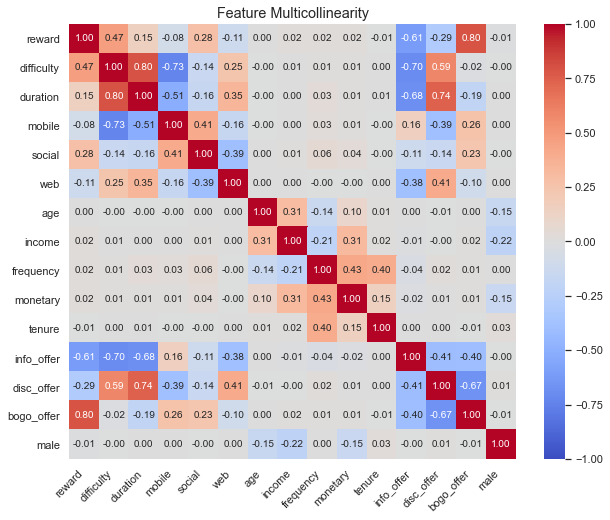

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='coolwarm')
plt.title('Feature Multicollinearity', fontsize='x-large')
plt.xticks(rotation=45, ha='right');

In [18]:
high_corr = ['duration', 'mobile', 'info_offer', 'disc_offer', 'bogo_offer']
low_corr_feats = np.setdiff1d(X_train.columns, high_corr)
low_corr_feats

array(['age', 'difficulty', 'frequency', 'income', 'male', 'monetary',
       'reward', 'social', 'tenure', 'web'], dtype=object)

##### High multicollinearity was found with the 3 `offer type` binary features, 3 `channel` binary features, and `duration` feature. These features won't be dropped as they may be good predictors for tree-based classifiers, but they will be omitted from classification algorithms where there is an assumption of no multicollinearity.

### <a id="prep7">7. Normalize values</a>

In [19]:
# Normalize train set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head(2)

,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,-0.342294,-0.114874,0.225353,0.32117,0.787324,0.500935,0.315473,-1.285855,0.557083,-0.309021,0.122169,-0.500327,1.211932,-0.807565,0.87684
1,-0.637000,0.436317,1.582750,0.32117,0.787324,0.500935,0.488569,-0.357779,1.773999,1.147328,0.982399,-0.500327,1.211932,-0.807565,0.87684


In [20]:
# Normalize validation set
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_val_scaled.head(2)

,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,0.247117,-0.482334,-0.679579,0.321170,0.787324,0.500935,1.527147,2.287238,-0.051376,0.551361,-0.523004,-0.500327,-0.825129,1.238291,0.87684
1,0.247117,2.273619,1.582750,-3.113619,-1.270125,0.500935,-0.492310,-0.357779,-1.673931,-0.932033,-0.451318,-0.500327,1.211932,-0.807565,0.87684


In [21]:
# Normalize test set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled.head(2)

,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,-0.637000,0.436317,0.225353,0.32117,-1.270125,0.500935,-1.357791,-1.425066,-0.862653,-0.874035,-1.168177,-0.500327,1.211932,-0.807565,0.87684
1,0.247117,-0.482334,-0.679579,0.32117,0.787324,0.500935,1.469448,0.384682,-1.065473,-0.477633,-0.738062,-0.500327,-0.825129,1.238291,0.87684


### <a id="prep8">8. PCA</a>

In [22]:
# Create components
pca = PCA(n_components=10, random_state=0)
pca.fit(X_train_scaled)
pca.explained_variance_ratio_.sum()

0.961347838685017

In [23]:
# Transform train set
X_train_pca = pca.transform(X_train_scaled)
X_train_pca = pd.DataFrame(X_train_pca, columns=['comp' + str(i) for i in range(10)])
print(X_train_pca.shape)
X_train_pca.head(2)

(33410, 10)


,comp0,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9
0,0.691450,-0.645447,-0.110821,1.304246,-1.246596,-0.812535,-0.659078,-0.323873,0.901158,-0.331617
1,1.595753,-0.560244,2.092137,1.289703,-1.320335,-0.684757,-0.903362,0.217998,0.741927,0.180403


In [24]:
# Transform validation set
X_val_pca = pca.transform(X_val_scaled)
X_val_pca = pd.DataFrame(X_val_pca, columns=['comp' + str(i) for i in range(10)])
print(X_val_pca.shape)
X_val_pca.head(2)

(11137, 10)


,comp0,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9
0,-0.920296,1.432925,0.587239,-1.974842,0.130724,-0.894055,-1.415897,1.244432,0.151065,-0.630723
1,4.042239,-0.920470,-2.155202,-0.083894,0.809632,1.755891,-0.399261,0.448724,-0.437092,-0.503487


In [25]:
# Transform test set
X_test_pca = pca.transform(X_test_scaled)
X_test_pca = pd.DataFrame(X_test_pca, columns=['comp' + str(i) for i in range(10)])
print(X_test_pca.shape)
X_test_pca.head(2)

(11137, 10)


,comp0,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9
0,1.220179,-1.416235,-2.177183,1.246938,-0.025106,-0.782515,0.598424,0.572972,0.066884,0.743792
1,-0.940575,1.294871,-1.158597,-1.223262,0.062796,-0.877021,-1.282211,0.267981,0.712579,-0.645277


In [26]:
del X_vt, y_vt, high_corr, to_drop
gc.collect()

18185

##### With the data preprocessed, we are left with 2 feature sets:
1. Set 1 with 8 features (no features with high multicollinearity) - `age`, `difficulty`, `frequency`, `income`, `male`, `monetary`, `reward`, `tenure`
2. Set 2 with 15 features - the features in set 1 plus `duration`, `mobile`, `social`, `web`, `info_offers`, `disc_offer`, `bogo_offer`

## <a id="clfr">Section III: Modeling</a>

### <a id="clfr1">1. Feature correlation with target</a>

In [27]:
# Correlation with target
target_corr = X_train.assign(target = y_train).corr().iloc[-1, :-1].sort_values(ascending=False)
target_corr

frequency     0.288992
monetary      0.283196
social        0.221276
mobile        0.159169
tenure        0.155593
income        0.115111
age           0.057705
disc_offer    0.039475
info_offer   -0.003099
web          -0.007438
duration     -0.015443
bogo_offer   -0.037109
reward       -0.057826
male         -0.090205
difficulty   -0.098174
Name: target, dtype: float64

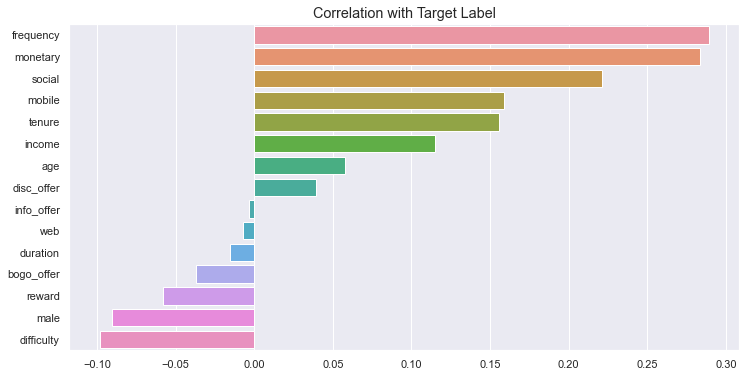

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Correlation with Target Label', fontsize='x-large');

##### If we were using a linear model, it looks like the spending habits of a customer would be the best predictor of whether or not they would complete an offer.

### <a id="clfr3">3. Evaluation functions</a>

In [29]:
def model_eval(train_pred, val_pred, test_pred=None,
               train_true=y_train, val_true=y_val, test_true=y_test):
    
    '''
    Get the accuracy and ROC-AUC scores of the train, validation, and test sets.
    
    Args:
        (1) train_pred (array-like) - predictions on training set
        (2) val_pred (array-like) - predictions on validation set
        (3) test_pred (array-like) - predictions on test set
        (4) train_true (array-like) - true labels from train set
        (5) val_true (array-like) - true labels from validation set
        (6) test_true (array-like) - true labels from test set
        
    Returns:
        Accuracy and ROC-AUC scores of the train, validation, and test sets (Pandas dataframe)
    '''
    
    metrics = dict()
    
    if train_pred is not None:
        metrics['train'] = [accuracy_score(train_true, train_pred)]
        metrics['train'].append(roc_auc_score(train_true, train_pred))
        
    if val_pred is not None:
        metrics['validation'] = [accuracy_score(val_true, val_pred)]
        metrics['validation'].append(roc_auc_score(val_true, val_pred))
        
    if test_pred is not None:
        metrics['test'] = [accuracy_score(test_true, test_pred)]
        metrics['test'].append(roc_auc_score(test_true, test_pred))
        
    return pd.DataFrame(metrics, index=['accuracy', 'ROC-AUC score']).T

In [30]:
def plot_roc(estimator, n_subplots, train_X, val_X, test_X=None,
             train_y=y_train, val_y=y_val, test_y=y_test):
    
    '''
    Plot the ROC curve for the train, validation, and test sets.
    
    Args:
        (1) estimator (Sklearn estimator) - fitted classifier
        (2) n_subplots (int) - number of sets to plot for
        (3) train_X (Pandas dataframe) - X from training set
        (4) val_X (Pandas dataframe) - X from validation set
        (5) test_X (Pandas dataframe) - X from test set
        (6) train_y (Pandas dataframe) - y from training set
        (7) val_y (Pandas dataframe) - y from validation set
        (8) test_y (Pandas dataframe) - y from test set
        
    Returns: None.
    '''
    
    fig, ax = plt.subplots(1, n_subplots, figsize=(16, 4))
    i = 0
    
    if train_X is not None:
        plot_roc_curve(estimator, train_X, train_y, ax=ax[i])
        ax[i].set_title('Train ROC')
        i += 1
        
    if val_X is not None:
        plot_roc_curve(estimator, val_X, val_y, ax=ax[i])
        ax[i].set_title('Validation ROC')
        i += 1
        
    if test_X is not None:
        plot_roc_curve(estimator, test_X, test_y, ax=ax[i])
        ax[i].set_title('Test ROC')

In [31]:
def plot_confusion(estimator, n_subplots, train_X, val_X, test_X=None,
                   train_y=y_train, val_y=y_val, test_y=y_test, color='Blues'):
    
    '''
    Plot a heatmap of the confusion matrix for the train, validation, and test sets.
    
    Args:
        (1) estimator (Sklearn estimator) - fitted classifier
        (2) n_subplots (int) - number of sets to plot for
        (3) train_X (Pandas dataframe) - X from training set
        (4) val_X (Pandas dataframe) - X from validation set
        (5) test_X (Pandas dataframe) - X from test set
        (6) train_y (Pandas dataframe) - y from training set
        (7) val_y (Pandas dataframe) - y from validation set
        (8) test_y (Pandas dataframe) - y from test set
        
    Returns: None.
    '''
    
    fig, ax = plt.subplots(1, n_subplots, figsize=(15, 3))
    i = 0
    
    if train_X is not None:
        plot_confusion_matrix(estimator, train_X, train_y, cmap=color, ax=ax[i])
        ax[i].set_title('Train Confusion Matrix')
        ax[i].grid(False)
        i += 1
        
    if val_X is not None:
        plot_confusion_matrix(estimator, val_X, val_y, cmap=color, ax=ax[i])
        ax[i].set_title('Validation Confusion Matrix')
        ax[i].grid(False)
        i += 1
        
    if test_X is not None:
        plot_confusion_matrix(estimator, test_X, test_y, cmap=color, ax=ax[i])
        ax[i].set_title('Test Confusion Matrix')
        ax[i].grid(False)

### <a id="clfr3">3. Logistic regression</a>

In [32]:
X_train_scaled_sub = X_train_scaled[low_corr_feats]
X_val_scaled_sub = X_val_scaled[low_corr_feats]
X_test_scaled_sub = X_test_scaled[low_corr_feats]
X_train_scaled_sub.shape, X_val_scaled_sub.shape, X_test_scaled_sub.shape

((33410, 10), (11137, 10), (11137, 10))

In [33]:
# Grid Search
lr = LogisticRegression(random_state=0)
lr_params = {'class_weight': [{0: w, 1: 1} for w in np.arange(1, 1.5, 0.2)],
             'C': np.logspace(-3, -1, 5),
             'penalty': ['l1', 'l2'],
             'solver': ['lbfgs', 'liblinear']}

lr_search = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=10, n_jobs=4)
lr_search.fit(X_train_scaled_sub, y_train)
print(lr_search.best_score_)
lr_search.best_params_

0.7645445306819436


{'C': 0.0031622776601683794,
 'class_weight': {0: 1.0, 1: 1},
 'penalty': 'l1',
 'solver': 'liblinear'}

In [34]:
# Train model
lr = lr_search.best_estimator_
lr.fit(X_train_scaled_sub, y_train)

# Make predictions
lr_train_pred = lr.predict(X_train_scaled_sub)
lr_val_pred = lr.predict(X_val_scaled_sub)

# Evaluate predictions
print(report(y_train, lr_train_pred))
print(report(y_val, lr_val_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71     16629
           1       0.71      0.67      0.69     16781

    accuracy                           0.70     33410
   macro avg       0.70      0.70      0.70     33410
weighted avg       0.70      0.70      0.70     33410

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      5697
           1       0.70      0.66      0.68      5440

    accuracy                           0.69     11137
   macro avg       0.69      0.69      0.69     11137
weighted avg       0.69      0.69      0.69     11137



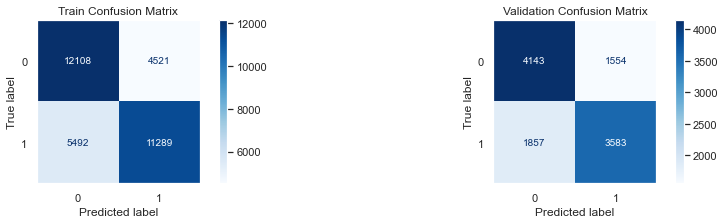

In [35]:
# Confusion matrix
plot_confusion(lr, 2, X_train_scaled_sub, X_val_scaled_sub)

In [36]:
# Coefficients
lr_coefs = pd.Series(lr.coef_[0], index=X_train_scaled_sub.columns).sort_values(ascending=False)
lr_coefs

social        0.535700
frequency     0.455692
monetary      0.398415
income        0.169808
web           0.140417
tenure        0.068043
age           0.052495
difficulty   -0.049684
male         -0.069628
reward       -0.220321
dtype: float64

##### The logistic regression model achieved an prediction accuracy and f1-score of 0.70 for both the training and validation sets. Since the target classes were balanced beforehand, we can see that there isn't much of a disparity between the false negatives and false positives.

##### It looks like the `social`, `frequency`, and `monetary` features have the most predictive power in this model. The posistive relationship between the customer's spending habits and their likelihood of completing an offer agrees with the analysis from the previous notebooks, but it's interesting to see that sending the offer through social media has an even greater importance here. Perhaps this is the main channel in which customers are responding to offers.

##### Surprisingly, `reward` has a negative coefficient, which is counterintuitive because one would expect that reward has a positive relationship with offer completion. Of course, this doesn't imply that lowering rewards would increase offer completions. It could just be that informational offers (which have 0 reward) are pulling this coefficient in the negative direction.

### <a id="clfr4">4. K-nearest Neighbors</a>